Use openai api to get answers to expert survey questions.

In [1]:
import os
import pandas as pd
from openai import OpenAI
import textwrap 
import json
from collections import defaultdict

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI"),
)


In [ ]:
questions = pd.read_csv('../../data/rdoc_questions_qualtrics.csv')
rename_dict = {'Task Name': 'task'}
questions.rename(columns=rename_dict, inplace=True)
# fix task names
for idx in questions.index:
    if ' task' not in questions.loc[idx, 'task']:
        questions.loc[idx, 'task'] = questions.loc[idx, 'task'] + ' task'
instructions = questions.loc[0, :]
questions = questions[1:]
del questions['Opinion']
del questions['Constructs']
del questions['Instructions']
# make long version across measure variables
questions_long = questions.melt(id_vars=['task', 'Explanation'], var_name='measure', value_name='question')

questions_long.dropna(subset=['question'], inplace=True)
questions_long.reset_index(drop=True, inplace=True)
questions_long

,task,Explanation,measure,question
0,Span task,The subject is presented sequentially with a l...,Measure 1,Simple Span
1,Spatial (Posner) Cueing task,"In this task, subjects see a cue, then a centr...",Measure 1,Valid - Neutral
2,Task Switching task,"A task switching task involves a cue (e.g., wo...",Measure 1,Cue Switch Cost
3,Visual Search task,The visual search task involves identifying a ...,Measure 1,Conjunction - Feature search
4,AX-CPT / Dot Pattern Expectancy (DPX) task,The AX-CPT task involves viewing a stream of l...,Measure 1,BX-BY
5,Flanker task,"In the flanker task, participants focus on a c...",Measure 1,Incongruent-congruent
6,Stroop task,"In the Stroop task, subjects see a series of c...",Measure 1,Incongruent-congruent
7,Stop-signal task,"In the stop-signal task, subjects make a speed...",Measure 1,Stop-signal reaction time
8,Go/nogo task,"In the go/nogo task, subjects respond with a s...",Measure 1,No-go trial performance
9,N-back task,The N-back task presents a series of stimuli i...,Measure 1,"High load (e.g., 2-back) - Low load (1-back)"


In [3]:

instructions = """

You will be presented with a specific measure from a cognitive psychology paradigm in which we would consider you an expert. 

We would like you to identify the latent cognitive constructs that are being measured by this particular measure. 

Many measures can be quantified in terms of reaction time, error rate, or both. We do
not distinguish between these, and you can think of such measures as a
performance metric in reaction time, error rate, or both.  

There are 13 possible responses.

The first 10 responses are cognitive constructs taken from the “cognitive systems”
domain of the National Institute of Mental Health (NIMH) Research Domain
Criteria (RDoC), contained in the following python list:

constructs = [
    "Attention",
    "Goal Selection",
    "Updating, Representation, and Maintenance",
    "Response Selection",
    "Inhibition/Suppression",
    "Performance Monitoring",
    "Active Maintenance",
    "Flexible Updating",
    "Limited Capacity",
    "Interference Control"
]

Please respond with a dictionary that includes a key called "constructs", 
which contains a list of all of the relevant constructs from the list above.

The dictionary should also contain a key "measure" that includes the name of the measure, 
and a key "task" that includes the name of the task.

If you believe that a measure does not map onto any of the constructs, you should respond an empty dictionary.

If you believe that a measure maps best onto a construct that is not provided on this list, 
you should respond with a dictionary with the key "Other:", containing a description of the construct that best fits the measure.

If you have additional comments or rationale, please include them in the "comments" key of the dictionary.
"""

span_task = """
In the span task, the subject is presented sequentially with a list of stimuli (e.g., a list of letters), and then is instructed to recall the list of stimuli. 
The number of stimuli is titrated up or down to increase or decrease load. 
The main dependent variable is the maximum number of stimuli that can be remembered, 
which is called the simple span. On some blocks of trials, the sequence of to-be-remembered 
stimuli is interleaved with an operation like a lexical decision (judge whether a string of 
letters is a word or not). In this operation span condition, the main dependent variable is 
the maximum number of stimuli that can be remembered while interleaving an operation, 
which is called the operation span."

The measure of interest is Operation Span - Simple Span.
"""

system_msg = """
You are an expert in cognitive psychology, particularly in the domain of cognitive control.
Your response should be in the JSON format.
"""

In [4]:
def run_gpt(input, system_msg, nruns=5):
    content = []
    for i in range(nruns):
        # Create a dataset using GPT
        chat_completion = client.chat.completions.create(
            response_format = {"type": "json_object"},
            messages=[
                {
                    "role": "system",
                    "content": system_msg
                },
                {
                    "role": "user",
                    "content": input
                }
            ],
            model="gpt-4o",
        )
        result = chat_completion.to_dict()
        result['input'] = input
        result['system_msg'] = system_msg
        content.append(result)
    return content

test = run_gpt(instructions + span_task, system_msg, nruns=1)

In [5]:
test

[{'id': 'chatcmpl-AQFr73K8vQvgj9hAYnWujYxZtZds3',
  'choices': [{'finish_reason': 'stop',
    'index': 0,
    'logprobs': None,
    'message': {'content': '{\n    "constructs": [\n        "Attention",\n        "Updating, Representation, and Maintenance",\n        "Limited Capacity"\n    ],\n    "measure": "Operation Span - Simple Span",\n    "task": "Span Task",\n    "comments": "The Operation Span - Simple Span measure assesses working memory capacity, which involves actively maintaining and updating the sequence of stimuli. Attention is needed to focus on the interleaved tasks and stimuli sequences. Limited capacity refers to the inherent restrictions in working memory capacity that this measure seeks to quantify."\n}',
     'refusal': None,
     'role': 'assistant'}}],
  'created': 1730820841,
  'model': 'gpt-4o-2024-08-06',
  'object': 'chat.completion',
  'system_fingerprint': 'fp_159d8341cc',
  'usage': {'completion_tokens': 108,
   'prompt_tokens': 559,
   'total_tokens': 667,
 

In [ ]:
outputs = defaultdict(lambda: defaultdict(list))
nruns = 10

for idx in questions_long.index:
    task = questions_long.loc[idx, 'task']
    measure = questions_long.loc[idx, 'question']
    explanation = questions_long.loc[idx, 'Explanation']
    print(f'running for task: {task} and measure: {measure}')

    task_desc = f"""
    This is for the {task}.
    
    {explanation}

    The measure of interest is: {measure}.
    """

    user_msg = f"{instructions} {task_desc}"
    outputs[task][measure] = run_gpt(user_msg, system_msg, nruns)

with open('../../data/gpt4_outputs.json', 'w') as f:
    json.dump(outputs, f, indent=4)



running for task: Span task and measure: Simple Span
running for task: Spatial (Posner) Cueing task and measure: Valid - Neutral
running for task: Task Switching task and measure: Cue Switch Cost
running for task: Visual Search task and measure: Conjunction - Feature search 
running for task: AX-CPT / Dot Pattern Expectancy (DPX) task and measure: BX-BY
running for task: Flanker task and measure: Incongruent-congruent
running for task: Stroop task and measure: Incongruent-congruent
running for task: Stop-signal task and measure: Stop-signal reaction time
running for task: Go/nogo task and measure: No-go trial performance
running for task: N-back task and measure: High load (e.g., 2-back) - Low load (1-back)
running for task: Span task and measure: Operation Span - Simple Span
running for task: Spatial (Posner) Cueing task and measure: Invalid - Neutral
running for task: Task Switching task and measure: Task Switch Cost
running for task: Visual Search task and measure: High - Low distra

In [10]:
resplist

{'constructs': ['Performance Monitoring',
  'Updating, Representation, and Maintenance',
  'Active Maintenance'],
 'measure': 'Post-error slowing',
 'task': 'N-back task',
 'comments': 'Post-error slowing reflects the cognitive control process where an individual slows down their response following an error. This is indicative of performance monitoring as the person may be adjusting their response strategy to avoid future errors. In the N-back task, it also involves updating and maintaining information about previous errors and responses in working memory, which are critical for adjusting future performance.'}

In [24]:
# convert responses to dataframe

output_list = []

for task, measures in outputs.items():
    for measure, responses in measures.items():
        for idx, response in enumerate(responses):
            measure_short = measure.split('(')[0]
            resplist = json.loads(response['choices'][0]['message']['content'])
            comments = resplist['comments'] if resplist['comments'] is not None else ''
            constructs = resplist['constructs'] if resplist['constructs'] is not None else []
            output_list.append([task, measure_short, idx, constructs, comments])

output_df = pd.DataFrame(output_list, columns=['task', 'measure', 'run', 'constructs', 'comments'])

In [28]:
exploded_df = output_df.drop('comments', axis=1).explode('constructs')
exploded_df.constructs.value_counts()

indicator_df = pd.get_dummies(exploded_df, columns=['constructs'], prefix='', prefix_sep='')


# Drop the 'run' column and group by 'task' and 'measure', then calculate the mean
grouped_df = indicator_df.drop('run', axis=1).groupby(['task', 'measure']).mean()



In [ ]:
grouped_df.to_csv('../../data/mean_concept_agreement.csv')

<Axes: ylabel='task-measure'>

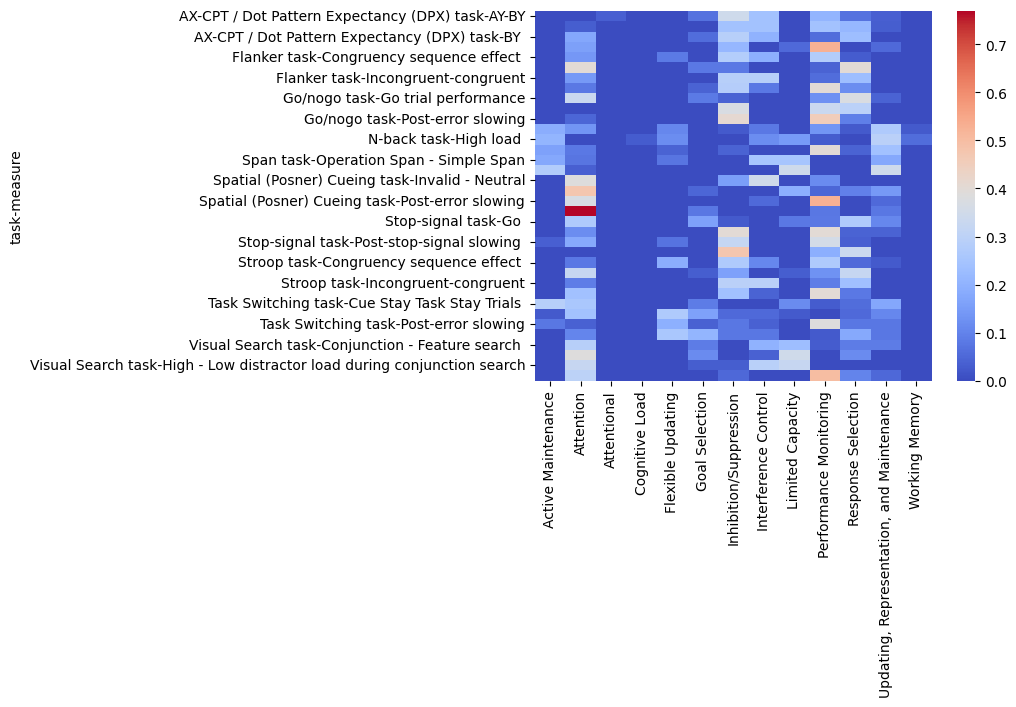

In [30]:
import seaborn as sns 

sns.heatmap(grouped_df, cmap='coolwarm')